In [376]:
import datetime
import orekit
import logging
import numpy as np
import math
import matplotlib.pyplot as plt

In [377]:
from org.hipparchus.geometry.euclidean.threed import RotationOrder
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.hipparchus.ode.events import Action

In [378]:
from org.orekit.forces.drag import DragForce
from org.orekit.forces.radiation import SolarRadiationPressure
from org.orekit.models.earth.atmosphere import HarrisPriester

In [379]:
from org.orekit.utils import Constants, PVCoordinates, ExtendedPVCoordinatesProvider


In [380]:
from org.orekit.attitudes import AttitudeProvider;
from org.orekit.attitudes import AttitudesSequence;
from org.orekit.attitudes import LofOffset;
from org.orekit.bodies import CelestialBodyFactory, OneAxisEllipsoid;
from org.orekit.errors import OrekitException;
from org.orekit.frames import FramesFactory;
from org.orekit.frames import LOFType;
from org.orekit.orbits import KeplerianOrbit, PositionAngle, OrbitType, CircularOrbit
from org.orekit.orbits import Orbit;
from org.orekit.propagation import Propagator;
from org.orekit.propagation import SpacecraftState;
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.propagation.events import EclipseDetector;
from org.orekit.propagation.events import EventDetector;
from org.orekit.propagation.events.handlers import EventHandler, PythonEventHandler;
from org.orekit.propagation.sampling import OrekitFixedStepHandler, PythonOrekitFixedStepHandler
from org.orekit.time import AbsoluteDate;
from org.orekit.time import TimeScalesFactory;
from org.orekit.utils import Constants, IERSConventions, AngularDerivativesFilter
from org.orekit.utils import PVCoordinates;
from org.orekit.utils import PVCoordinatesProvider
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.propagation.numerical import NumericalPropagator
from org.orekit.propagation import SpacecraftState
from orekit import JArray_double
from org.orekit.forces import BoxAndSolarArraySpacecraft


In [381]:
from org.orekit.attitudes import InertialProvider
from org.orekit.attitudes import NadirPointing
from org.orekit.propagation.sampling import OrekitFixedStepHandler, PythonOrekitFixedStepHandler
from org.orekit.frames import LocalOrbitalFrame, LOFType
from org.hipparchus.geometry.euclidean.threed import RotationOrder, RotationConvention

In [382]:
# set up directory for orekit data
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [383]:
def sso_orbit(**kwargs):
    """Computes keplerian elements of sunsynchronous orbit given the type of sso orbit.
    All units are SI.
    """
    Re = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
    J2 = 1082e-6
    mu = 3.98600442e14 #Constants.WGS84_EARTH_MU
    raandot = 1.991063853e-7
    k = -3*Re**2*J2*np.sqrt(mu)/(2*raandot)

    a = kwargs["a"] if "a" in kwargs else None
    i = kwargs["i"] if "i" in kwargs else None
    e = kwargs["e"] if "e" in kwargs else None
    time = kwargs["time"] if "time" in kwargs else datetime.datetime.utcnow()
    hrs_from_noon = kwargs["hrs_from_noon"] if "hrs_from_noon" in kwargs else 0.0


    if e is not None and i is not None:
        a = np.power(k*np.cos(i)/((1-e**2)**2), 2.0/7.0)
    elif e is not None and a is not None:
        i = np.arccos(np.power(a, 7.0/2.0)*(1-e**2)**2/k)
    elif a is not None and i is not None:
        e = np.sqrt(1 - np.sqrt(k*np.cos(i)/a**(7.0/2.0)))
    else:
        raise ValueError("Insufficient arguments to compute sso. Provide either of (a,i), (a,e), (e,i).")

    ## Compute RAAN given type of SSO
    eme = FramesFactory.getEME2000()
    sun = CelestialBodyFactory.getSun()
    sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)
    sun_coordinates = sun_pv.getPVCoordinates(datetime_to_absolutedate(time), eme)
    sun_position = np.array([sun_coordinates.getPosition().getX(), sun_coordinates.getPosition().getY(), sun_coordinates.getPosition().getZ()])
    theta_sun = np.arctan2(sun_position[1], sun_position[0])
    # theta_sun = np.arccos(sun_position[0]/np.linalg.norm(sun_position))
    print(f"date: {time}, sun position: {sun_position}")
    print(f"sun angle: {np.rad2deg(theta_sun)}")
    raan = theta_sun + hrs_from_noon*2*np.pi/24.0
    if raan < 0:
        raan = 2*np.pi + raan
    return a, e, i, raan

In [384]:
def quat2dcm(q0, q):
    q1 = q[0]
    q2 = q[1]
    q3 = q[2]

    return np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2*(q1*q2 + q0*q3),                                2*(q1*q3 - q0*q2)],
        [2*(q1*q2 - q0*q3),                                q0**2 - q1**2 + q2**2 - q3**2, 2*(q2*q3 + q0*q1)],
        [2*(q1*q3 + q0*q2),                                2*(q2*q3 - q0*q1),             q0**2 - q1**2 - q2**2 + q3**2],
    ])

## Define Frames

In [385]:
inertial_frame = FramesFactory.getEME2000()
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [386]:
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                Constants.WGS84_EARTH_FLATTENING,
                                earth_frame)

In [387]:
sun = CelestialBodyFactory.getSun()

## Define Time

In [388]:
initialDate =  datetime_to_absolutedate(datetime.datetime.utcnow())
duration = float(24*60*60.0)

## Define Initial Orbit

In [389]:

sma = 567.45129e3 + Constants.WGS84_EARTH_EQUATORIAL_RADIUS 
a, e, i, raan = sso_orbit(a=sma, e=0.0, hrs_from_noon=-6.0, time=absolutedate_to_datetime(initialDate))


date: 2021-10-14 13:00:13.170083, sun position: [-1.39194350e+11 -4.92998080e+10 -2.13710949e+10]
sun angle: -160.49688982513683


In [390]:
sma

6945588.29

In [391]:
i

1.7045753155503345

In [392]:
raan

1.911189813725466

In [393]:
initial_orbit = CircularOrbit(float(a), float(0.0), float(0.0), float(i),
                              float(raan), float(0.0),
                              PositionAngle.MEAN, inertial_frame,
                              initialDate, Constants.WGS84_EARTH_MU)
position = initial_orbit.getPVCoordinates().getPosition()
velocity = initial_orbit.getPVCoordinates().getVelocity()

## Define Attitude Law

In [394]:

inertialAttitudeLaw = NadirPointing(inertial_frame, earth_shape) # nadir pointing law keeps fixed rotation 

In [395]:
initial_attitude = inertialAttitudeLaw.getAttitude(initial_orbit, initialDate, inertial_frame)

In [396]:
q0 = initial_attitude.getRotation().getQ0()
q = np.array([
    initial_attitude.getRotation().getQ1(),
    initial_attitude.getRotation().getQ2(),
    initial_attitude.getRotation().getQ3()
])
dcm = quat2dcm(q0, q)
print(dcm)

[[ 1.25726002e-01  4.45340259e-02  9.91064929e-01]
 [-9.34201148e-01 -3.30874461e-01  1.33380309e-01]
 [ 3.33858036e-01 -9.42623367e-01  4.21512238e-06]]


In [397]:
xhat = position.normalize()
zhat = position.crossProduct(velocity).normalize()
yhat = zhat.crossProduct(xhat).normalize()

In [398]:
xhat

<Vector3D: {-0.333858028; 0.9426233697; 0}>

In [399]:
yhat

<Vector3D: {0.1257273966; 0.044530087; 0.9910649288}>

In [400]:
zhat

<Vector3D: {0.9342009628; 0.3308749827; -0.1333803093}>

In [401]:
initial_attitude.getRotation().getAngle()

2.217516479373025

In [402]:
lvlh_frame = LocalOrbitalFrame(inertial_frame, LOFType.LVLH, initial_orbit, "LVLH")

In [403]:
initial_attitude_lvlh = inertialAttitudeLaw.getAttitude(initial_orbit, initialDate, lvlh_frame)

In [404]:
q0 = initial_attitude_lvlh.getRotation().getQ0()
q = np.array([
    initial_attitude_lvlh.getRotation().getQ1(),
    initial_attitude_lvlh.getRotation().getQ2(),
    initial_attitude_lvlh.getRotation().getQ3()
])
dcm = quat2dcm(q0, q)
print(dcm)

[[ 4.17856930e-06  1.00000000e+00  2.31459296e-12]
 [ 5.53971565e-07 -2.22044605e-16 -1.00000000e+00]
 [-1.00000000e+00  4.17856930e-06 -5.53971565e-07]]


# How Nadir Pointing Works!

$$\hat{x}_{B} \rightarrow  \hat{y}_{lvlh}$$
$$\hat{y}_{B} \rightarrow -\hat{z}_{lvlh}$$
$$\hat{z}_{B} \rightarrow -\hat{x}_{lvlh}$$

## Define Initial State

In [405]:
initial_sc_state = SpacecraftState(initial_orbit, initial_attitude)

In [406]:
initial_attitute_rate_y = initial_sc_state.getAttitude().getSpin().getY()
print(np.rad2deg(initial_attitute_rate_y*initial_sc_state.getKeplerianPeriod()))
print("there is a constant rate of rotation of 360deg/orbitperiod about the spacecraft y-axis which is pointing opposite to h-vector.")

-362.1883081865487
there is a constant rate of rotation of 360deg/orbitperiod about the spacecraft y-axis which is pointing opposite to h-vector.


In [407]:
Vector3D(float(1.0), float(0.0), float(0.0))

<Vector3D: {1; 0; 0}>

In [408]:
solar_panel_area = float(1.5 * 1.6)
xlength = float(0.58)
ylength = float(0.45)
zlength = float(0.41)
solar_array_rot_axis =  Vector3D.PLUS_I
solar_array_normal =  Vector3D.PLUS_J
solar_array_rot_rate = float(0.0)
drag_coeff = float(2.25)
lift_ratio = float(0.1)
absorption_coeff = float(0.5)
reflection_coeff = float(0.5)
sc_shape = BoxAndSolarArraySpacecraft(xlength, ylength, zlength,
                                      sun, solar_panel_area, solar_array_rot_axis,
                                      initialDate, solar_array_normal,
                                      solar_array_rot_rate, drag_coeff, lift_ratio, absorption_coeff,
                                      reflection_coeff)


In [409]:
drag_force = DragForce(HarrisPriester(sun, earth_shape, float(4.0)), sc_shape)

In [410]:
solar_panel_efficiency = 0.2

In [411]:
from org.orekit.models.earth.atmosphere.data import CssiSpaceWeatherData
space_weather_data_provider = CssiSpaceWeatherData("^S(?:pace)?W(?:eather)?-(?:All)?.*\\.txt$")
# print(space_weather_data_provider.getAverageFlux(initialDate)*100e6*1e-22)
print(space_weather_data_provider.getInstantFlux(initialDate))

77.68051616154884


In [412]:
solar_irradiance = 1367 

In [413]:
sun

<CelestialBody: org.orekit.bodies.JPLCelestialBody@5b068087>

In [414]:
sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)
sun_coordinates = sun_pv.getPVCoordinates(initial_sc_state.getDate(), inertial_frame).getPosition().normalize()

In [415]:
sun_coordinates.dotProduct(zhat)

-0.961741679446796

In [416]:
np.rad2deg(np.arccos(zhat.getX()))

20.90056397783544

In [417]:
sun_coordinates

<Vector3D: {-0.932904019; -0.3304156316; -0.1432326839}>

In [418]:
zhat

<Vector3D: {0.9342009628; 0.3308749827; -0.1333803093}>

In [419]:
np.rad2deg(np.arctan2(sun_coordinates.getY(), sun_coordinates.getX()))

-160.4968898251261

In [420]:
np.rad2deg(raan)

109.50311017486317

In [421]:
class propagation_handler(PythonOrekitFixedStepHandler):

    spins = []

    power = []

    def init(self, s0, t, step):
        pass

    def handleStep(self, currentState, isLast):
        inertToSpacecraft = currentState.toTransform()
        spin = inertToSpacecraft.getRotationRate()
        self.spins.append([spin.getX(), spin.getY(), spin.getZ()])
        sun = CelestialBodyFactory.getSun()
        sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)
        sun_coordinates = sun_pv.getPVCoordinates(currentState.getDate(), inertial_frame).getPosition().normalize()
        sun_position = np.array([
            sun_coordinates.getX(),
            sun_coordinates.getY(),
            sun_coordinates.getZ()
        ])
        attitude = currentState.getAttitude()
        q0 = attitude.getRotation().getQ0()
        q = np.array([
            attitude.getRotation().getQ1(),
            attitude.getRotation().getQ2(),
            attitude.getRotation().getQ3()
        ])
        dcm = quat2dcm(q0, q)
        print(f"[BN]: {dcm}")
        solar_array_axis = dcm[1, :]
        print(f"SAA: {solar_array_axis}")
        position = currentState.getPVCoordinates().getPosition()
        velocity = currentState.getPVCoordinates().getVelocity()
        xhat = position.normalize()
        zhat = position.crossProduct(velocity).normalize()
        print(f"h vector: {zhat}")
        watts = solar_panel_efficiency * solar_irradiance * solar_panel_area * np.dot(
            solar_array_axis, sun_position)
        print(np.rad2deg(np.arccos(np.dot(solar_array_axis, sun_position))))
        print(np.rad2deg(np.arccos(np.dot(np.array([zhat.getX(), zhat.getY(), zhat.getZ()]), sun_position))))
        print(np.dot(solar_array_axis, np.array([zhat.getX(), zhat.getY(), zhat.getZ()])))
        print(np.rad2deg(np.arccos(np.dot(solar_array_axis, np.array([zhat.getX(), zhat.getY(), zhat.getZ()])))))
        self.power.append(watts)

In [422]:
min_step = float(0.001)
max_step = float(10.0)
position_tolerance = float(1.0)
propagation_type = OrbitType.KEPLERIAN
tolerances = NumericalPropagator.tolerances(position_tolerance, initial_orbit,
                                            propagation_type)
integator = DormandPrince853Integrator(min_step, max_step,
                                       JArray_double.cast_(tolerances[0]),
                                       JArray_double.cast_(tolerances[1]))
propagator = NumericalPropagator(integator, inertialAttitudeLaw)
# propagator = NumericalPropagator(integator) # this one implements an inertial provider by default

propagator.setInitialState(initial_sc_state)


In [423]:
propagator.addForceModel(drag_force)

In [424]:
handler = propagation_handler()
propagator.setMasterMode(180.0, handler)

In [425]:
propagator.propagate(initialDate, initialDate.shiftedBy(duration))

[BN]: [[ 1.25726002e-01  4.45340259e-02  9.91064929e-01]
 [-9.34201148e-01 -3.30874461e-01  1.33380309e-01]
 [ 3.33858036e-01 -9.42623367e-01  4.21512238e-06]]
SAA: [-0.93420115 -0.33087446  0.13338031]
h vector: {0.9342009628; 0.3308749827; -0.1333803093}
15.89992263953613
164.1000773604947
-0.9999999999998466
179.99996826074224
[BN]: [[ 0.18878796 -0.14128144  0.97180176]
 [-0.93415351 -0.33102112  0.13335003]
 [ 0.30284702 -0.93298691 -0.19447136]]
SAA: [-0.93415351 -0.33102112  0.13335003]
h vector: {0.9342009628; 0.3308749827; -0.1333803093}
15.8989474855837
164.0993035315399
-0.9999999877376821
179.99102728410372
[BN]: [[ 0.24446467 -0.32144616  0.91482752]
 [-0.93412088 -0.33114796  0.13326371]
 [ 0.26010616 -0.88713775 -0.38122355]]
SAA: [-0.93412088 -0.33114796  0.13326371]
h vector: {0.9342009628; 0.3308749827; -0.1333803093}
15.894734256289206
164.09852947750048
-0.9999999527374238
179.98238444514394
[BN]: [[ 0.29058689 -0.48887141  0.82253511]
 [-0.93410821 -0.33123555  0.1

<SpacecraftState: SpacecraftState{orbit=equinoctial parameters: {a: 6945587.262752526; ex: -3.2494780017661904E-8; ey: 3.879926530441348E-8; hx: -0.38179951789899125; hy: 1.077982610150711; lv: 5508.856536181548;}, attitude=org.orekit.attitudes.Attitude@4b508371, mass=1000.0, additional={}}>

In [426]:
from orekit.pyhelpers import absolutedate_to_datetime 

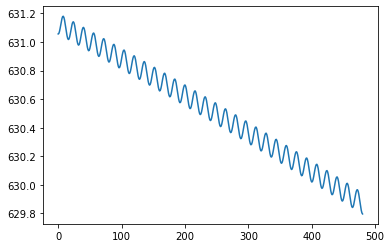

In [427]:
fig_p = plt.figure()
ax_p = fig_p.add_subplot(111)
ax_p.plot(np.array(handler.power))

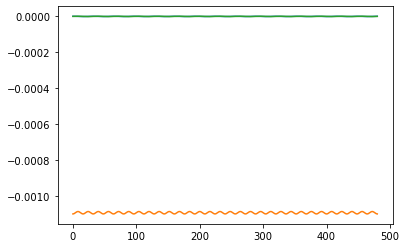

In [428]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(handler.spins)[:, 0])
ax.plot(np.array(handler.spins)[:, 1])
ax.plot(np.array(handler.spins)[:, 2])